In [2]:
from multiprocessing import freeze_support
from legacy_processors import preprocess_leaderboard_replays
from legacy_processors import get_leaderboard_replays
from legacy_processors import generate_data

from legacy_processors import pre_segment_size
from legacy_processors import post_segment_size
from legacy_processors import prediction_size
from legacy_processors import note_size
from legacy_processors import speed_stuff

from legacy_processors import segment_size

input_shape = (segment_size, note_size)
num_threads = 16
batch_size = 256

if __name__ == '__main__':
  freeze_support()

  train_data, val_data = get_leaderboard_replays(100, 20)
  test_data = val_data
#   time_scales = [1, 1.5] might be possible to emulate FS/SFS modifiers
  time_scales = [1]
  val_x, val_y = generate_data(val_data, num_threads, time_scales)
  train_x, train_y = generate_data(train_data, num_threads, time_scales)


 58%|█████▊    | 363/626 [00:20<00:08, 29.32it/s]

368474 - Expecting ',' delimiter: line 1 column 1254079 (char 1254078)


 45%|████▌     | 1138/2504 [00:45<00:50, 26.79it/s]

350835 - division by zero


 58%|█████▊    | 1460/2504 [00:57<00:30, 33.97it/s]

314403 - division by zero


 79%|███████▉  | 1981/2504 [01:15<00:19, 26.30it/s]

192694 - division by zero


100%|██████████| 2504/2504 [02:24<00:00, 17.34it/s]


In [6]:
len(train_x)

NameError: name 'train_x' is not defined

In [3]:
from keras import Input, Model
from keras.layers import Bidirectional, LSTM, Concatenate, Cropping1D, TimeDistributed, Dense
import os
import pathlib
import time
import datetime

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import json
import random
import csv
import concurrent.futures
from multiprocessing import freeze_support

from keras import layers
from keras import models
from keras import mixed_precision


# Input layer
input_layer = Input(shape=input_shape, name="input_1")

bidirectional_1 = layers.Bidirectional(layers.LSTM(units=12, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=12, return_sequences=True, go_backwards=True, activation="tanh"))(input_layer)
bidirectional_2 = layers.Bidirectional(layers.LSTM(units=10, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=10, return_sequences=True, go_backwards=True, activation="tanh"))(bidirectional_1)

# Concatenate the output of the second bidirectional LSTM layer with the input
concatenate = Concatenate()([bidirectional_2, input_layer])

# Cropping1D layer
cropping1d = Cropping1D(cropping=(12, 12))(concatenate)  # Adjust the cropping as necessary

# TimeDistributed layer with Dense layer inside
time_distributed_1 = TimeDistributed(Dense(units=16, activation='relu'))(cropping1d)

# Another TimeDistributed layer with Dense layer inside
time_distributed_2 = TimeDistributed(Dense(units=16, activation='relu'))(time_distributed_1)

# Final TimeDistributed layer with Dense layer for output
time_distributed_3 = TimeDistributed(Dense(units=1, activation='linear'), name="time_distributed_2")(time_distributed_2)

# Create the model
model = Model(inputs=input_layer, outputs=time_distributed_3)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 32, 49)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 24)    │      5,952 │ input_1[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 20)    │      2,800 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 69)    │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d          │ (None, 8, 69)     │          0 │ concatenate[0][0] │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 16)     │      1,120 │ cropping1d[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 8, 16)     │        272 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 8, 1)      │         17 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,161 (39.69 KB)

 Trainable params: 10,161 (39.69 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

global initial_epoch
initial_epoch = 0

class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global initial_epoch
        initial_epoch += 1

def custom_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)**1

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     monitor='val_mae',
#     filepath=f"models/{'speed' if speed_stuff else 'acc'}/{start_time.strftime('%Y-%m-%d-%H-%M-%S')}",
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1)


# model2 = tf.keras.models.load_model("model_sleep_lstm_acc", custom_objects={"custom_loss": custom_loss})
# model = tf.keras.models.load_model(f'model_sleep_2gru_{"speed" if speed_stuff else "acc"}')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True),
    # loss=tf.keras.losses.Huber(delta=5),
    loss='mse',
    metrics=['mae', 'mse'],
)


history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    callbacks=[tensorboard_callback, EpochCallback()],
    batch_size=128,
    epochs=initial_epoch + 40,
    initial_epoch=initial_epoch,
    shuffle=True,
    verbose=1,
)

Epoch 1/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - loss: 0.0399 - mae: 0.1101 - mse: 0.0399 - val_loss: 0.0053 - val_mae: 0.0497 - val_mse: 0.0053
Epoch 2/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0051 - mae: 0.0495 - mse: 0.0051 - val_loss: 0.0049 - val_mae: 0.0477 - val_mse: 0.0049
Epoch 3/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0048 - mae: 0.0479 - mse: 0.0048 - val_loss: 0.0048 - val_mae: 0.0471 - val_mse: 0.0048
Epoch 4/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0046 - mae: 0.0472 - mse: 0.0046 - val_loss: 0.0047 - val_mae: 0.0467 - val_mse: 0.0047
Epoch 5/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0045 - mae: 0.0467 - mse: 0.0045 - val_loss: 0.0046 - val_mae: 0.0463 - val_mse: 0.0046
Epoch 6/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0044 - mae: 0.0464 - mse: 0.0044 - val_loss: 0.0045 - val_mae: 0.0458 - val_mse: 0.0045
Epoch 7/40
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - loss: 0.0044 - mae

In [5]:
import tensorflow as tf
import tf2onnx
import onnx

model.save("restored_model_sleep_4LSTM_acc.keras")

# Convert the saved model to ONNX
spec = (tf.TensorSpec((None, segment_size, note_size), tf.float32, name="input_1"),)
output_path = "restored_model_sleep_4LSTM_acc.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=None, output_path=output_path)

print(f"Model is converted to ONNX and saved at {output_path}")



Model is converted to ONNX and saved at restored_model_sleep_4LSTM_acc.onnx


287692 Watch me dance easy predicted acc - 99.30438995361328 -- real acc 99.48757549067194




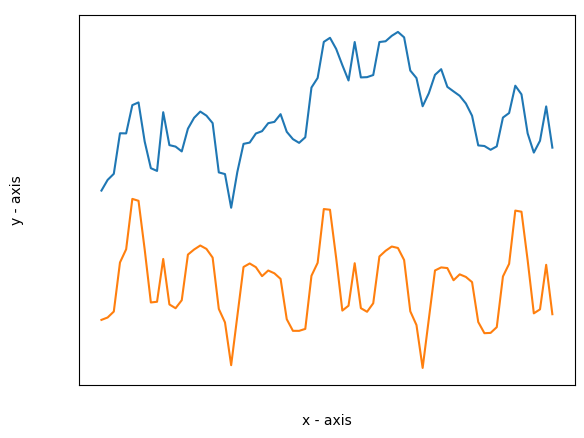

129587 Magnetism easy predicted acc - 99.4279556274414 -- real acc 99.58149021009424




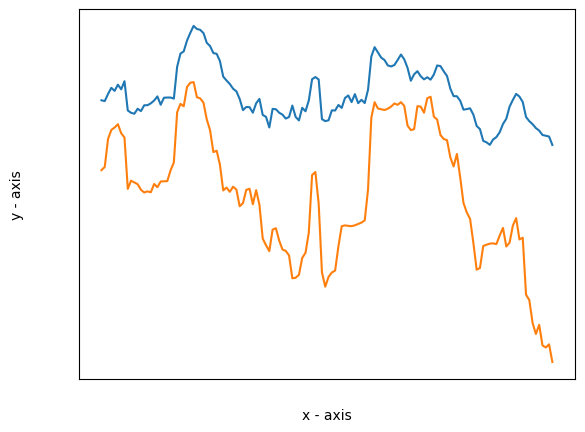

129454 Magnetism normal predicted acc - 99.06289672851562 -- real acc 99.15181902195944




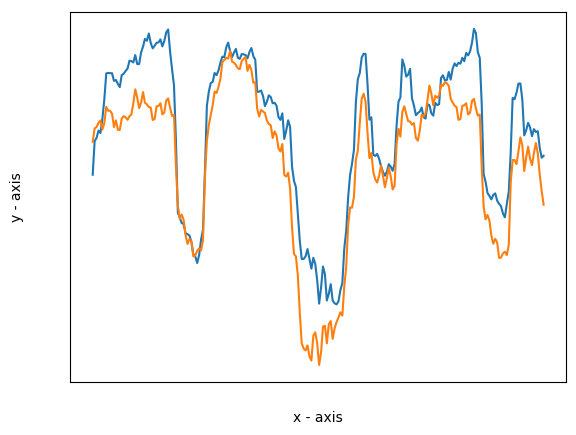

129470 Magnetism hard predicted acc - 98.50640106201172 -- real acc 98.31969596890386




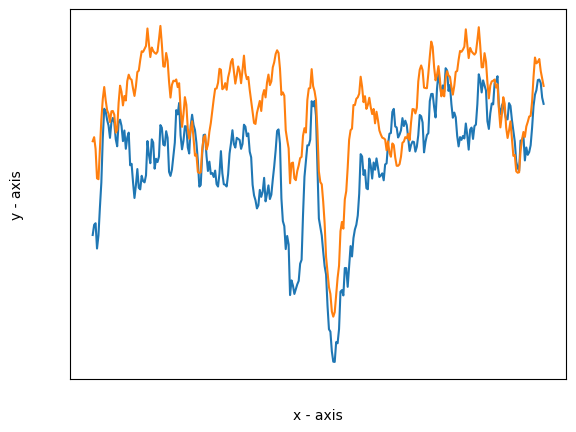

129449 Magnetism expert+ predicted acc - 97.01959991455078 -- real acc 96.78207551413654




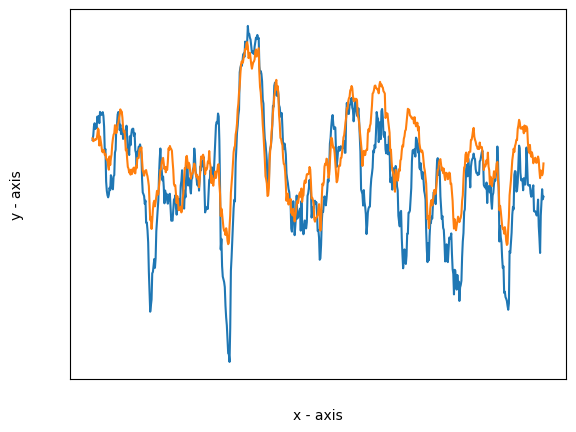

280301 sacrament ex+ predicted acc - 96.32305908203125 -- real acc 96.18013394476559




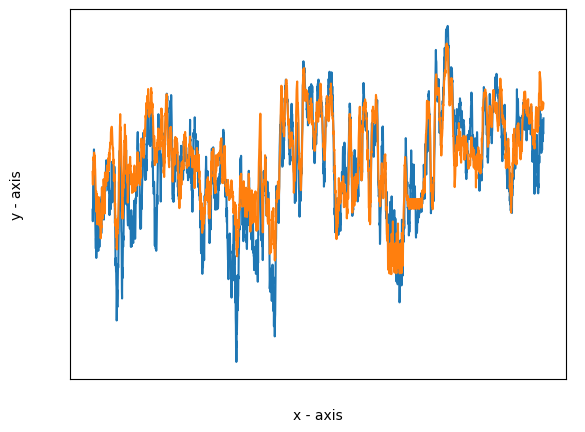

304958 rotten ex+ predicted acc - 96.61328125 -- real acc 96.48923807317394




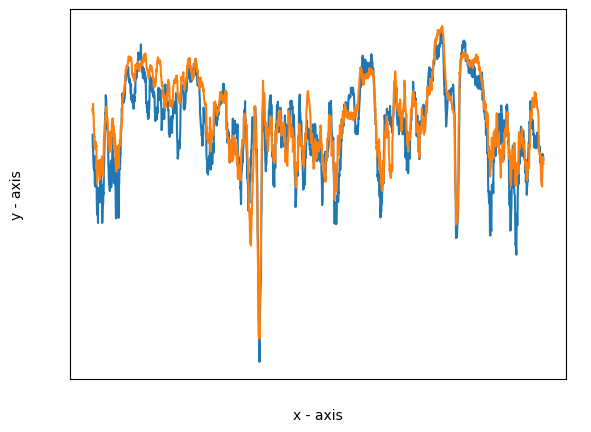

212829 melan stroller ex+ predicted acc - 96.51154327392578 -- real acc 96.2201767372748




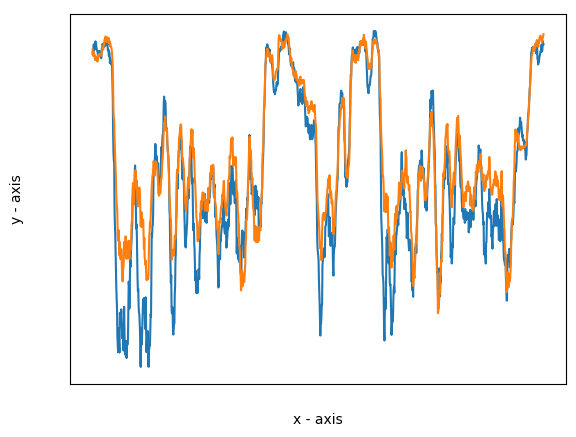

In [7]:
import matplotlib.pyplot as plt
import time
from legacy_processors import generate_data_sync

hmm = [
        ["287692", "Watch me dance easy"],
        ["129587", "Magnetism easy"],
        ["129454", "Magnetism normal"],
        ["129470", "Magnetism hard"],
        ["129450", "Magnetism expert"],
        ["129449", "Magnetism expert+"],
        ["280301", "sacrament ex+"],
        ["304958", "rotten ex+"],
        ["212829", "melan stroller ex+"],
        ["219625", "toromi 2 ex+"],
        ["297487", "ludicrous ex+"]]
    # hmm = ["86346", "86338"]
    # for val_data_this in val_data:
for val_data_this, map_name in hmm:
    val_xx, val_yy = generate_data_sync([val_data_this], [1], True)
    if len(val_xx) == 0:
        continue

    acc = []
    acc_real = []
    
    speeds = [[], [], []]
    speeds_real = [[], [], []]
    
    complexities = []
    complexities_real = []

    for batch_pred, batch_inp in zip(model(val_xx), val_yy):
        for pred, inp in zip(batch_pred, batch_inp):
            if inp == 0.0:
                continue
            
            acc.append(pred[0])
            acc_real.append(inp)
            
            # for i in range(3):
            #     speeds[i].append(pred[i+1])
            #     speeds_real[i].append(inp[i+1])
            
            # complexities.append(pred[1]*(1-pred[0]))
            # complexities_real.append(inp[1]*(1-inp[0]))


    print(f"{val_data_this} {map_name} predicted acc - {(sum(acc)/len(acc)*15+100)/1.15} -- real acc {(sum(acc_real)/len(acc_real)*15+100)/1.15}")
    # for i in range(3):
    #     print(f"{val_data_this} speed - {sum(speeds[i])/len(speeds[i])} -- {sum(speeds_real[i])/len(speeds_real[i])}")
    # print(f"{val_data_this} complexity - {sum(complexities)/len(complexities)} -- {sum(complexities_real)/len(complexities_real)}")
    
    print("")
    print("")
    
    # complexities = np.convolve(complexities, np.ones(30)/30, mode='valid')
    # speed = np.convolve(speed, np.ones(30)/30, mode='valid')
    # acc = np.convolve([(acc_*15+100)/115 for acc_ in acc], np.ones(30)/30, mode='valid')
    acc_real = np.convolve(acc_real, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc_real))]
    plt.plot(x, acc_real)
    acc = np.convolve(acc, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc))]
    plt.plot(x, acc)
    
    # plt.plot(x, complexities)
    # for i in range(3):
    #     plt.plot(x, np.convolve(speeds[i], np.ones(30)/30, mode='valid'))
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.show()

In [9]:
import plotly.graph_objects as go
import json

# Load JSON data from a file
with open('restored_comparison.json', 'r', encoding="utf8") as file:
    data = json.load(file)

# Extract accuracy, prod, and stage values
accuracy = [item["accuracy"] for item in data]
prod = [item["prod"] for item in data]
stage = [item["stage"] for item in data]

# Create interactive scatter plot
fig = go.Figure()

# Add "prod" scatter plot
fig.add_trace(go.Scatter(x=accuracy, y=prod,
                         mode='markers',
                         name='Prod',
                         marker=dict(color='blue')))

# Add "stage" scatter plot
fig.add_trace(go.Scatter(x=accuracy, y=stage,
                         mode='markers',
                         name='Stage',
                         marker=dict(color='red')))

# Update layout for better visualization
fig.update_layout(title='Interactive Plot: Accuracy vs. Prod and Stage',
                  xaxis_title='Accuracy',
                  yaxis_title='Prod/Stage',
                  legend_title='Parameters',
                  hovermode='closest')

# Show plot
fig.show()
